# N-BEATS Time Series Forecasting
In this tutorial we utilize the N-BEATS (Neural basis expansion analysis for interpretable time series forecasting
) for forecasting the price of ethereum.

For more details regarding N-BEATS, visit this link [https://arxiv.org/abs/1905.10437](https://arxiv.org/abs/1905.10437)

The code for N-BEATS used is adapted from [nbeats-pytorch](https://pypi.org/project/nbeats-pytorch/)

In [56]:
import numpy as np
import pandas as pd
import torch
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.nn.functional import mse_loss, l1_loss, binary_cross_entropy, cross_entropy
from torch.optim import Optimizer
import matplotlib.pyplot as plt
import requests
import json
from torch.utils.data import DataLoader, TensorDataset


In [57]:
# Fetch data
coins = ["ETH"]
days_ago_to_fetch = 2000 # 7 years
coin_history = {}
hist_length = 0
average_returns = {}
cumulative_returns = {}

def index_history_coin(hist):
    hist = hist.set_index('time')
    hist.index = pd.to_datetime(hist.index, unit='s')
    return hist

def filter_history_by_date(hist):
    result = hist[hist.index.year >= 2017]
    return result

def fetch_history_coin(coin):
    endpoint_url = "https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym=USD&limit={:d}".format(coin, days_ago_to_fetch)
    res = requests.get(endpoint_url)
    hist = pd.DataFrame(json.loads(res.content)['Data'])
    hist = index_history_coin(hist)
    hist = filter_history_by_date(hist)
    return hist

def get_history_from_file(filename):
    return pd.read_csv(filename)


for coin in coins:
    coin_history[coin] = fetch_history_coin(coin)

hist_length = len(coin_history[coins[0]])


In [58]:
# save to file
# coin_history['ETH'].to_csv("eth_price.csv")

In [59]:
# read from file
coin_history['ETH'] = get_history_from_file("eth_price.csv")

In [60]:
# calculate returns

def add_all_returns():
    for coin in coins:
        hist = coin_history[coin]
        hist['return'] = (hist['close'] - hist['open']) / hist['open']
        average = hist["return"].mean()
        average_returns[coin] = average
        cumulative_returns[coin] = (hist["return"] + 1).prod() - 1
        hist['excess_return'] = hist['return'] - average
        coin_history[coin] = hist

add_all_returns()

# display data
cumulative_returns

{'ETH': 1.9760112200995046}

In [61]:
# average return per day
average_returns

{'ETH': 0.0017096654072490103}

In [62]:
# Excess matrix
excess_matrix = np.zeros((hist_length, len(coins)))

for i in range(0, hist_length):
    for idx, coin in enumerate(coins):
        excess_matrix[i][idx] = coin_history[coin].iloc[i]['excess_return']

excess_matrix

array([[ 0.00558812],
       [-0.04525188],
       [ 0.00375009],
       ...,
       [-0.04195583],
       [ 0.0248929 ],
       [-0.00422064]])

In [63]:
# pretty print excess matrix
pretty_matrix = pd.DataFrame(excess_matrix).copy()
pretty_matrix.columns = coins
pretty_matrix.index = coin_history[coins[0]].index

pretty_matrix

,ETH
0,0.005588
1,-0.045252
2,0.003750
3,-0.071924
4,-0.078560
...,...
1996,-0.002229
1997,-0.013010
1998,-0.041956
1999,0.024893


In [64]:
# Risk modelling

# variance co-var matrix
product_matrix = np.matmul(excess_matrix.transpose(), excess_matrix)
var_covar_matrix = product_matrix / hist_length

var_covar_matrix

array([[0.002284]])

In [65]:
# pretty var_covar
pretty_var_covar = pd.DataFrame(var_covar_matrix).copy()
pretty_var_covar.columns = coins
pretty_var_covar.index = coins

pretty_var_covar

,ETH
ETH,0.002284


In [66]:
# Std dev

std_dev = np.zeros((len(coins), 1))
neg_std_dev = np.zeros((len(coins), 1))

for idx, coin in enumerate(coins):
    std_dev[idx][0] = np.std(coin_history[coin]['return'])
    coin_history[coin]['downside_return'] = 0

    coin_history[coin].loc[coin_history[coin]['return'] < 0,
                           'downside_return'] = coin_history[coin]['return']**2
    neg_std_dev[idx][0] = np.sqrt(coin_history[coin]['downside_return'].mean())

In [67]:
# pretty std
pretty_std = pd.DataFrame(std_dev).copy()
pretty_neg_std = pd.DataFrame(neg_std_dev).copy()
pretty_comb = pd.concat([pretty_std, pretty_neg_std], axis=1)

pretty_comb.columns = ['std dev', 'neg std dev']
pretty_comb.index = coins

pretty_comb

,std dev,neg std dev
ETH,0.047791,0.033226


In [68]:
# std_product_mat
std_product_matrix = np.matmul(std_dev, std_dev.transpose())

# neg_prod_mat
neg_std_product_matrix = np.matmul(neg_std_dev, neg_std_dev.transpose())

In [69]:
pretty_std_prod = pd.DataFrame(std_product_matrix).copy()
pretty_std_prod.columns = coins
pretty_std_prod.index = coins

pretty_std_prod

,ETH
ETH,0.002284


In [70]:
# Corr matrix
corr_matrix = var_covar_matrix / std_product_matrix
pretty_corr = pd.DataFrame(corr_matrix).copy()
pretty_corr.columns = coins
pretty_corr.index = coins

pretty_corr

,ETH
ETH,1.0


In [71]:
# see additional stuff we have added to the DF
coin_history['ETH']

,time,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol,return,excess_return,downside_return
0,2018-03-23,543.84,506.79,539.89,432407.55,2.252001e+08,543.83,direct,NaN,0.007298,0.005588,0.000000e+00
1,2018-03-24,546.01,519.51,543.84,241529.67,1.293504e+08,520.16,direct,NaN,-0.043542,-0.045252,1.895925e-03
2,2018-03-25,535.77,513.63,520.17,213514.32,1.114623e+08,523.01,direct,NaN,0.005460,0.003750,0.000000e+00
3,2018-03-26,526.20,467.48,522.97,567723.19,2.786568e+08,486.25,direct,NaN,-0.070214,-0.071924,4.930055e-03
4,2018-03-27,491.92,446.42,486.14,712309.54,3.281792e+08,448.78,direct,NaN,-0.076850,-0.078560,5.905967e-03
...,...,...,...,...,...,...,...,...,...,...,...,...
1996,2023-09-09,1636.97,1629.50,1636.13,29804.48,4.870422e+07,1635.28,direct,NaN,-0.000520,-0.002229,2.698996e-07
1997,2023-09-10,1635.60,1601.75,1635.28,87587.77,1.417714e+08,1616.80,direct,NaN,-0.011301,-0.013010,1.277085e-04
1998,2023-09-11,1618.60,1531.48,1616.80,222845.65,3.504662e+08,1551.73,direct,NaN,-0.040246,-0.041956,1.619754e-03
1999,2023-09-12,1622.80,1549.47,1551.73,182674.67,2.909126e+08,1593.01,direct,NaN,0.026603,0.024893,0.000000e+00


In [72]:
def simulate_portfolio_growth(initial_amount, daily_returns):
    portfolio_value = [initial_amount]
    for ret in daily_returns:
        portfolio_value.append(portfolio_value[-1] * (1 + ret))
    return portfolio_value

initial_investment = 100000

eth_portfolio = simulate_portfolio_growth(initial_investment, coin_history["ETH"]['return'])

print("ETH Portfolio Growth:", eth_portfolio)

ETH Portfolio Growth: [100000, 100729.77828816982, 96343.78029268609, 96869.79358839947, 90068.14374124564, 83146.38077137496, 82618.3554912858, 71125.93158815199, 72952.42832077826, 72996.88553022647, 70177.55749771945, 71257.49721056545, 77046.19635746721, 70140.50982317928, 70642.5058131986, 68590.44130749576, 71299.98135428572, 74215.09826040152, 73900.25081819078, 76980.19962052276, 79715.66828020067, 91488.07906086369, 91675.14852103469, 93125.3998805783, 98933.81401024463, 94768.35520185315, 93168.10779836259, 97381.72219991467, 105062.53930902964, 114306.56105766546, 112084.03123169857, 115077.03806400066, 119299.84473333776, 130268.02942448435, 114402.14645491431, 122520.80530520882, 119171.63284044692, 126565.19570637215, 127730.7473461383, 124159.97149585311, 124302.65428800254, 127254.52036454865, 144094.79588473123, 145286.044743713, 151286.90549078814, 146432.91888323886, 139394.63830229244, 138542.40031907824, 139187.13688029247, 134062.59283340003, 125571.94342755074, 1

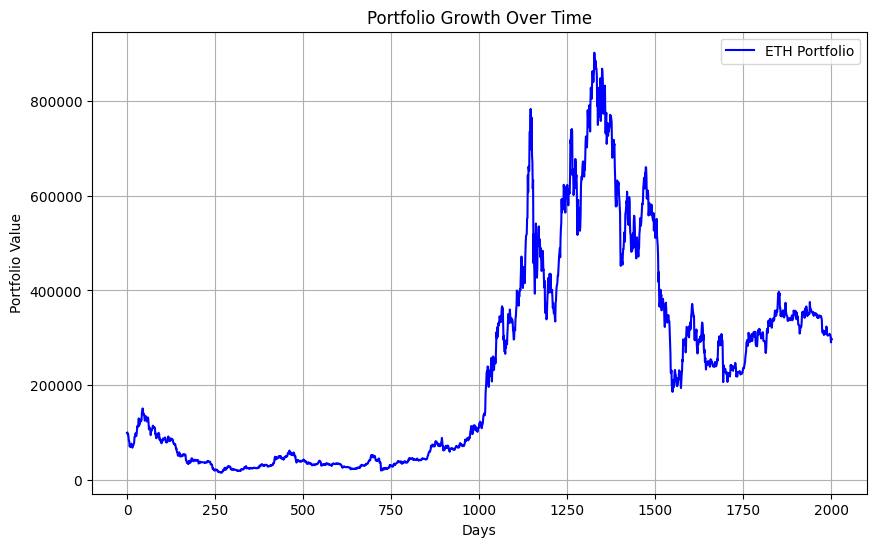

In [73]:
# Plotting the growth
plt.figure(figsize=(10,6))
plt.plot(eth_portfolio, label='ETH Portfolio', color='blue')
plt.title('Portfolio Growth Over Time')
plt.xlabel('Days')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()

In [76]:
# close dataframe
eth_df = coin_history['ETH'][['close']].copy()

# Convert to tensor
close_tensor = torch.tensor(eth_df.values)

# return dataframe
eth_df = coin_history['ETH'][['return']].copy()

# Convert to tensor
return_tensor = torch.tensor(eth_df.values)

# return_tensor = torch.tensor(eth_df.values)
print(close_tensor)
print(return_tensor)

tensor([[ 543.8300],
        [ 520.1600],
        [ 523.0100],
        ...,
        [1551.7300],
        [1593.0100],
        [1589.0100]], dtype=torch.float64)
tensor([[ 0.0073],
        [-0.0435],
        [ 0.0055],
        ...,
        [-0.0402],
        [ 0.0266],
        [-0.0025]], dtype=torch.float64)


In [77]:
# Adapted from https://pypi.org/project/nbeats-pytorch/
# author = {Philippe Remy},

def squeeze_last_dim(tensor):
    if len(tensor.shape) == 3 and tensor.shape[-1] == 1:  # (128, 10, 1) => (128, 10).
        return tensor[..., 0]
    return tensor


def seasonality_model(thetas, t, device):
    p = thetas.size()[-1]
    assert p <= thetas.shape[1], 'thetas_dim is too big.'
    p1, p2 = (p // 2, p // 2) if p % 2 == 0 else (p // 2, p // 2 + 1)
    s1 = torch.tensor(np.array([np.cos(2 * np.pi * i * t) for i in range(p1)])).float()  # H/2-1
    s2 = torch.tensor(np.array([np.sin(2 * np.pi * i * t) for i in range(p2)])).float()
    S = torch.cat([s1, s2])
    return thetas.mm(S.to(device))


def trend_model(thetas, t, device):
    p = thetas.size()[-1]
    assert p <= 4, 'thetas_dim is too big.'
    T = torch.tensor(np.array([t ** i for i in range(p)])).float()
    return thetas.mm(T.to(device))


def linear_space(backcast_length, forecast_length, is_forecast=True):
    horizon = forecast_length if is_forecast else backcast_length
    return np.arange(0, horizon) / horizon

class Block(nn.Module):

    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, share_thetas=False,
                 nb_harmonics=None):
        super(Block, self).__init__()
        self.units = units
        self.thetas_dim = thetas_dim
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
        self.share_thetas = share_thetas
        self.fc1 = nn.Linear(backcast_length, units)
        self.fc2 = nn.Linear(units, units)
        self.fc3 = nn.Linear(units, units)
        self.fc4 = nn.Linear(units, units)
        self.device = device
        self.backcast_linspace = linear_space(backcast_length, forecast_length, is_forecast=False)
        self.forecast_linspace = linear_space(backcast_length, forecast_length, is_forecast=True)
        if share_thetas:
            self.theta_f_fc = self.theta_b_fc = nn.Linear(units, thetas_dim, bias=False)
        else:
            self.theta_b_fc = nn.Linear(units, thetas_dim, bias=False)
            self.theta_f_fc = nn.Linear(units, thetas_dim, bias=False)

    def forward(self, x):
        x = squeeze_last_dim(x)
        x = F.relu(self.fc1(x.to(self.device)))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x

    def __str__(self):
        block_type = type(self).__name__
        return f'{block_type}(units={self.units}, thetas_dim={self.thetas_dim}, ' \
               f'backcast_length={self.backcast_length}, forecast_length={self.forecast_length}, ' \
               f'share_thetas={self.share_thetas}) at @{id(self)}'


class SeasonalityBlock(Block):

    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, nb_harmonics=None):
        if nb_harmonics:
            super(SeasonalityBlock, self).__init__(units, nb_harmonics, device, backcast_length,
                                                   forecast_length, share_thetas=True)
        else:
            super(SeasonalityBlock, self).__init__(units, forecast_length, device, backcast_length,
                                                   forecast_length, share_thetas=True)

    def forward(self, x):
        x = super(SeasonalityBlock, self).forward(x)
        backcast = seasonality_model(self.theta_b_fc(x), self.backcast_linspace, self.device)
        forecast = seasonality_model(self.theta_f_fc(x), self.forecast_linspace, self.device)
        return backcast, forecast


class TrendBlock(Block):

    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, nb_harmonics=None):
        super(TrendBlock, self).__init__(units, thetas_dim, device, backcast_length,
                                         forecast_length, share_thetas=True)

    def forward(self, x):
        x = super(TrendBlock, self).forward(x)
        backcast = trend_model(self.theta_b_fc(x), self.backcast_linspace, self.device)
        forecast = trend_model(self.theta_f_fc(x), self.forecast_linspace, self.device)
        return backcast, forecast



class GenericBlock(Block):

    def __init__(self, units, thetas_dim, device, backcast_length=10, forecast_length=5, nb_harmonics=None):
        super(GenericBlock, self).__init__(units, thetas_dim, device, backcast_length, forecast_length)

        self.backcast_fc = nn.Linear(thetas_dim, backcast_length)
        self.forecast_fc = nn.Linear(thetas_dim, forecast_length)

    def forward(self, x):
        # no constraint for generic arch.
        x = super(GenericBlock, self).forward(x)

        theta_b = self.theta_b_fc(x)
        theta_f = self.theta_f_fc(x)

        backcast = self.backcast_fc(theta_b)  # generic. 3.3.
        forecast = self.forecast_fc(theta_f)  # generic. 3.3.

        return backcast, forecast


class NBEATS(nn.Module):
    SEASONALITY_BLOCK = 'seasonality'
    TREND_BLOCK = 'trend'
    GENERIC_BLOCK = 'generic'

    def __init__(
        self,
        device=torch.device("cpu"),
        stack_types=(GENERIC_BLOCK, GENERIC_BLOCK),
        nb_blocks_per_stack=1,
        forecast_length=7,
        backcast_length=14,
        theta_dims=(2,2),
        share_weights_in_stack=False,
        hidden_layer_units=32,
        nb_harmonics=None,
    ):
        super(NBEATS, self).__init__()
        self.forecast_length = forecast_length
        self.backcast_length = backcast_length
        self.hidden_layer_units = hidden_layer_units
        self.nb_blocks_per_stack = nb_blocks_per_stack
        self.share_weights_in_stack = share_weights_in_stack
        self.nb_harmonics = nb_harmonics  # for seasonal data
        self.stack_types = stack_types
        self.stacks = nn.ModuleList()
        self.thetas_dim = theta_dims
        self.device = device
        print('| N-Beats')
        for stack_id in range(len(self.stack_types)):
            stack = self.create_stack(stack_id)
            self.stacks.append(stack)
        self.to(self.device)
        # self.asset_weight_layer = nn.Softmax(dim=1)
        # self.asset_classes = asset_classes


    def create_stack(self, stack_id):
        stack_type = self.stack_types[stack_id]
        print(f'| --  Stack {stack_type.title()} (#{stack_id}) (share_weights_in_stack={self.share_weights_in_stack})')
        blocks = nn.ModuleList()
        for block_id in range(self.nb_blocks_per_stack):
            block_init = NBEATS.select_block(stack_type)
            if self.share_weights_in_stack and block_id != 0:
                block = blocks[-1]  # pick up the last one when we share weights.
            else:
                block = block_init(
                    self.hidden_layer_units, self.thetas_dim[stack_id],
                    self.device, self.backcast_length, self.forecast_length,
                    self.nb_harmonics
                )
            print(f'     | -- {block}')
            blocks.append(block)
        return blocks

    @staticmethod
    def select_block(block_type):
        if block_type == NBEATS.SEASONALITY_BLOCK:
            return SeasonalityBlock
        elif block_type == NBEATS.TREND_BLOCK:
            return TrendBlock
        else:
            return GenericBlock


    def get_generic_and_interpretable_outputs(self):
        g_pred = sum([a['value'][0] for a in self._intermediary_outputs if 'generic' in a['layer'].lower()])
        i_pred = sum([a['value'][0] for a in self._intermediary_outputs if 'generic' not in a['layer'].lower()])
        outputs = {o['layer']: o['value'][0] for o in self._intermediary_outputs}
        return g_pred, i_pred,

    def forward(self, backcast):
        self._intermediary_outputs = []
        backcast = squeeze_last_dim(backcast)
        forecast = torch.zeros(size=(backcast.size()[0], self.forecast_length,))  # maybe batch size here.
        for stack_id in range(len(self.stacks)):
            for block_id in range(len(self.stacks[stack_id])):
                b, f = self.stacks[stack_id][block_id](backcast)
                backcast = backcast.to(self.device) - b
                forecast = forecast.to(self.device) + f
                block_type = self.stacks[stack_id][block_id].__class__.__name__
                layer_name = f'stack_{stack_id}-{block_type}_{block_id}'

        return backcast, forecast


In [78]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, close_data, return_data, backcast_length, forecast_length, shuffle=True):
        self.close_data = close_data
        self.return_data = return_data
        self.backcast_length = backcast_length
        self.forecast_length = forecast_length
        self.indices = list(range(len(self.close_data) - self.backcast_length - self.forecast_length + 1))
        if shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return len(self.close_data) - self.backcast_length - self.forecast_length + 1

    def __getitem__(self, idx):
        start = idx
        end = idx + self.backcast_length
        x = self.close_data[start:end]  # Take columns as needed
        y = self.close_data[end:end+self.forecast_length]  # Adjust as per forecast columns needed
        return x, y

# Hyperparameters
BACKCAST_LENGTH = 14
FORECAST_LENGTH = 7

train_length = round(len(close_tensor) * 0.7)
train_dataset = TimeSeriesDataset(close_tensor[0:train_length], return_tensor[0:train_length], BACKCAST_LENGTH, FORECAST_LENGTH)
test_dataset = TimeSeriesDataset(close_tensor[train_length:], return_tensor[train_length:], BACKCAST_LENGTH, FORECAST_LENGTH)
train_loader = DataLoader(train_dataset)

model = NBEATS(forecast_length=FORECAST_LENGTH, backcast_length=BACKCAST_LENGTH, device=('cuda' if torch.cuda.is_available() else 'cpu'))
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')


| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=32, thetas_dim=2, backcast_length=14, forecast_length=7, share_thetas=False) at @138646255690384
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=32, thetas_dim=2, backcast_length=14, forecast_length=7, share_thetas=False) at @138646255686976


In [79]:
EPOCHS = 1

num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters in model: {num_parameters}")

criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(EPOCHS):
    total_loss = 0.0
    for batch_idx, (x, y) in enumerate(train_loader):
        # Zero gradients
        optimizer.zero_grad()

        x = x.clone().detach().to(dtype=torch.float)
        x = x.to('cuda' if torch.cuda.is_available() else 'cpu')
        y = y.clone().detach().to(dtype=torch.float)
        y = y.to('cuda' if torch.cuda.is_available() else 'cpu')


        # Forward pass
        forecast = model(x)

        loss = criterion(forecast[0], y)

        # Backprop and optimize
        loss.backward()
        optimizer.step()

        # add positive gain for logging
        total_loss += loss  # add the positive gain_loss for logging

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{EPOCHS}, Average Loss: {avg_loss:.4f}")

Number of trainable parameters in model: 7678


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1, 7, 1])) that is different to the input size (torch.Size([1, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Epoch 1/1, Average Loss: 119.9735


In [80]:
# check if notebook is in colab
try:
    # install ezkl
    import google.colab
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "ezkl"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "onnx"])

# rely on local installation of ezkl if the notebook is not in colab
except:
    pass

import ezkl
import os
import json

In [81]:
model_path = os.path.join('network.onnx')
compiled_model_path = os.path.join('network.compiled')
pk_path = os.path.join('test.pk')
vk_path = os.path.join('test.vk')
settings_path = os.path.join('settings.json')
srs_path = os.path.join('kzg.srs')
witness_path = os.path.join('witness.json')
data_path = os.path.join('input.json')

In [82]:
# After training, export to onnx (network.onnx) and create a data file (input.json)
x_export = None
for batch_idx, (x, y) in enumerate(train_loader):
    x_export = x.clone().detach().to(dtype=torch.float)
    break

# Flips the neural net into inference mode
model.eval()

    # Export the model
torch.onnx.export(model,               # model being run
                      x_export,                   # model input (or a tuple for multiple inputs)
                      model_path,            # where to save the model (can be a file or file-like object)
                      export_params=True,        # store the trained parameter weights inside the model file
                      opset_version=10,          # the ONNX version to export the model to
                      do_constant_folding=True,  # whether to execute constant folding for optimization
                      input_names = ['input'],   # the model's input names
                      output_names = ['output'], # the model's output names
                      dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                    'output' : {0 : 'batch_size'}})

data_array = ((x).detach().numpy()).reshape([-1]).tolist()

data = dict(input_data = [data_array])

    # Serialize data into file:
json.dump( data, open(data_path, 'w' ))

============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



<ipython-input-77-b8d6d7e9a228>:5: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if len(tensor.shape) == 3 and tensor.shape[-1] == 1:  # (128, 10, 1) => (128, 10).


In [ ]:
!RUST_LOG=trace
# TODO: Dictionary outputs
res = ezkl.gen_settings(model_path, settings_path)
assert res == True

res = await ezkl.calibrate_settings(data_path, model_path, settings_path, "resources")
assert res == True

In [ ]:
res = ezkl.compile_model(model_path, compiled_model_path, settings_path)
assert res == True

In [ ]:
# srs path
res = ezkl.get_srs(srs_path, settings_path)

In [ ]:
res = ezkl.gen_witness(data_path, compiled_model_path, witness_path, settings_path = settings_path)
assert os.path.isfile(witness_path)

In [ ]:
res = ezkl.setup(
        compiled_model_path,
        vk_path,
        pk_path,
        srs_path,
        settings_path,
    )

assert res == True
assert os.path.isfile(vk_path)
assert os.path.isfile(pk_path)
assert os.path.isfile(settings_path)

In [ ]:
proof_path = os.path.join('test.pf')

res = ezkl.prove(
        witness_path,
        compiled_model_path,
        pk_path,
        proof_path,
        srs_path,
        "evm",
        "single",
        settings_path,
    )

print(res)
assert os.path.isfile(proof_path)

In [ ]:
# VERIFY IT

res = ezkl.verify(
        proof_path,
        settings_path,
        vk_path,
        srs_path,
    )

assert res == True
print("verified")